In [1]:
from turtle import color
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from ordered_set import OrderedSet
import copy 
from statistics import mean
from sklearn.preprocessing import normalize
import pickle
from scipy.stats import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from statistics import stdev
from sklearn.metrics import accuracy_score

In [2]:
import pyhsmm
import pyhsmm.internals
import pyhsmm.basic.distributions as distributions

In [3]:
class SemiMarkov():

    def __init__(self):
        pass
 
    def df_col_diff(self, df, columns):
            """Places the difference betweeen to rows of dataframe in a new column named with '_diff' """
            
            df_columns = df.columns

            for col in columns: 
                if col in df_columns:
                    df[col+'_diff'] = df[col].diff()
                else:
                    for column in df_columns:
                        if col in column and column+'_diff' not in df.columns:
                            df[column+'_diff'] = df[column].diff()
            return df

    def transition_matrix(transitions):
        n = 1+ max(transitions) #number of states

        M = [[0]*n for _ in range(n)]

        for (i,j) in zip(transitions,transitions[1:]):
            M[i][j] += 1

        #now convert to probabilities:
        for row in M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]
        return M

    
    def save_model(self, model, kappa, iter, fig = 'save'):

        with open('HSMM_Models/{}_{}_{}_{}kap_{}iter.pickle'.format(device_name,feature_names,model_name,kappa, iter),'wb') as outfile:
            pickle.dump(model,outfile,protocol=-1)
            
        fig = plt.figure()
                
        plt.clf()
        model.plot()
        #model.plot_observations()
        #model.plot_stateseq()
        plt.gcf().suptitle('HDP-HSMM for {}_{}_{}_{}kap_{}iter'.format(device_name,feature_names,model_name, kappa, iter)) 
        plt.tight_layout()
        
        
        if fig == 'save':
            plt.savefig('figures/HSMM/{}_{}_{}_{}kap_{}iter.png'.format(device_name,feature_names,model_name, kappa, iter))
        else:
            plt.show()


    def run_HSMM(self, data, features, extra_states = 0, model_count = 4, kappa = 0.05, progprint_xrange_var = 400):


        true_labels= data['state']
        
        states = list(OrderedSet(true_labels)) 
        
        data = data.drop(data.columns[[0,-1]], axis=1)
        
        Nmax = len(states) + extra_states
        
        data = data.reset_index(drop=True)

        #data = normalize(data[['cpu_user_time_diff','cpu_system_time_diff','cpu_idle_time_diff','memory','net_sent_diff']])
        data = data[features].to_numpy() 
        
        obs_dim = len(data[0])
        
        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                'sigma_0':np.eye(obs_dim),
                'kappa_0': kappa,
                'nu_0':obs_dim+10}
                
        dur_hypparams = {'alpha_0':2*10,
                         'beta_0':2}

        distributions.DurationDistribution

        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=6., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

        posteriormodel.add_data(data)

        models = []
                
        for idx in pyhsmm.pyhsmm.util.text.progprint_xrange(progprint_xrange_var):
            posteriormodel.resample_model()
            if (idx+1) % int(progprint_xrange_var/model_count) == 0:
                models.append(copy.deepcopy(posteriormodel))
                
        model = models[-1]
        return model, model.stateseqs, true_labels, states
    
    
    def get_HSMM_state_seq(self, data, model_path, device_name, model_count = 4, progprint_xrange_var = 400, plot = False):
        
        objects = []
        true_labels = data['state']
        
        with (open(model_path, "rb")) as openfile:
            while True:
                try:
                    objects.append(pickle.load(openfile))
                except EOFError:
                    break

        model = objects[0]
            
        if plot == True:
            model.plot()
            plt.gcf().suptitle('HDP-HSMM for {}'.format(device_name))
            plt.tight_layout()
            plt.show()
            
        return objects[0], objects[0].stateseqs, true_labels
        
    def HSMM_pred(self, model, seed_start, seed_end, pred_window):
        
        global df
        
        obs, stateseq = model.predict(df[seed_start:seed_end],pred_window)
        log_likelihood = model.log_likelihood(obs)

        return obs, stateseq, log_likelihood
    
    def metrics_plots(self, obs, pred_obs, features):# pred_stateseq, labels_running, labels_top_cpu, features):
               
                      
        """
        plt.plot(real_stateseq[0], color = 'red', label = 'states')
        plt.plot(pred_stateseq, color = 'blue', label = 'predicted')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
        """
        obs_dict = {feature:[] for feature in features}
        pred_obs_dict = {feature:[] for feature in features}
        
        results_dict = {}
        
        for pred_ob in pred_obs:
            for feature in features:
                pred_obs_dict[feature].append(pred_ob[features.index(feature)])
                
        for ob in obs:
            for feature in features:
                obs_dict[feature].append(ob[features.index(feature)])
                
        for feature in features:

            results_dict[feature+'_observations'] = obs_dict[feature]
            results_dict[feature+'_predicted_observations'] = pred_obs_dict[feature]
            
            results_dict[feature+'_rmse'] = sqrt(mean_squared_error(obs_dict[feature],pred_obs_dict[feature]))
            results_dict[feature+'_mae'] = mean_absolute_error(obs_dict[feature],pred_obs_dict[feature])


            """state_sequences
            plt.plot(data[feature][test_start_idx:], color = 'red', label = 'obs')
            plt.plot(pred_obs_dict[feature][test_start_idx:], color = 'blue', label = 'predicted')
            plt.title(feature)
            plt.legend(loc='best')
            plt.grid()
            plt.show()
            """
            
        return results_dict 
        
    def merge_datasets(self, save, df_path, dataset_list):

        df = pd.concat(dataset_list)
        
        if save == True:
            df.to_csv(df_path)
            
        return df
    
    def merge_dataset(self, device_name,dataset_name_list, new_name):
        
        prep_data_list = list()
        num_list = ''
        
        for dataset_name in dataset_name_list:
            prep_data_list.append(pd.read_csv('data/{}_res_usage_data_{}.csv'.format(device_name,dataset_name), index_col = 'time_stamp'))
        
        return self.merge_datasets(True, 'data/{}_res_usage_data_{}.csv'.format(device_name, new_name), prep_data_list)

    def preprocess_data(self, device_name, freq, data_name):
        """Preprocessing labeled data"""

        #Read Data, create difference feature, and clean nans
        labeled_data = pd.read_csv(f'data/{device_name}_{freq}MHz_res_usage_data_{data_name}.csv', index_col = 'time_stamp')
        labeled_data = SM.df_col_diff(labeled_data, diff_columns)
        labeled_data = labeled_data.fillna(0)


        #Move label column to the end
        labeled_data_cols = labeled_data.columns.tolist()
        oldindex = labeled_data_cols.index('state')
        labeled_data_cols.insert(len(labeled_data_cols), labeled_data_cols.pop(oldindex))
        labeled_data = labeled_data[labeled_data_cols]
        
        # remove first row due to diff = 0
        labeled_data = labeled_data.iloc[1: , :] 
        # remove rows with tranisition saving data states
        labeled_data = labeled_data[labeled_data['state'] != 'transition']
        labeled_data = labeled_data[labeled_data['state'] != 'saving data']

        # For quick test
        #labeled_data = labeled_data[:2000] #for testing only

        # train/test split        
        labeled_data_train = labeled_data[:int(0.7*len(labeled_data))]
        labeled_data_test = labeled_data[int(0.7*len(labeled_data)):]
        

        return labeled_data_train, labeled_data_test

    def check_duplicate_label(self, dict):
        
        for key1, val1 in dict.items():

            for key2, val2 in dict.items():
                if key1 != key2:
                    if val2 == val1:
                        print('Duplicate labels detected, not saving model')
                        return False
                        
                    else:
                        pass
        return True
        
        
    
    def grid_search(self, extras, kappas, iters, save='save'):
        
        max_accuracy = 0
        best_extra, best_kappa, best_iter = 0, 0, 0

        for extra in extras:
            for kap in kappas:
                for iter in iters:

                    print(f'Training for {extra} extra states, kappa = {kap}, and iters = {iter}')

                    
                    temp_model, temp_statesseqs, temp_true_labels, temp_states = self.run_HSMM(labeled_data_train, features, extra_states = extra, kappa = kap, progprint_xrange_var =iter) 
                    
                    labeled_data_train['predicted'] = temp_statesseqs[0]
                    Labels = {}
                    Accuracies = []

                    for name, _ in labeled_data_train.groupby('state'):
                        print(name)
                        label = labeled_data_train.groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
                        print(label)
                        Labels[name] = label.idxmax()
                        Accuracies.append(label.max())

                    avg_acc = mean(Accuracies)
                    
                    print(Labels)
                    print(f'Accuracies: {Accuracies}')
                    print(f'Average Accuracy = {avg_acc}')

                    if SM.check_duplicate_label(Labels):

                        if avg_acc > max_accuracy:
                
                            max_accuracy = avg_acc
                            best_model, best_state_sequences, best_true_labels, best_states = temp_model, temp_statesseqs, temp_true_labels, temp_states                  
                            best_extra, best_kappa, best_iter = extra, kap, iter
                  
                            print(f'Model saved for {best_extra} extra states, kappa = {best_kappa}, and iters = {best_iter}')
                            self.save_model(best_model, best_kappa, best_iter, save) 

        return best_model, best_state_sequences, best_true_labels, best_states

In [4]:
SM = SemiMarkov()

features = ['cpu_user_time_diff','cpu_system_time_diff','cpu_idle_time_diff','memory']#,'net_sent_diff']
diff_columns = ['cpu_user_time', 'cpu_system_time','cpu_idle_time', 'net_sent', 'net_recv', 'io_counters_read_count_', 'io_counters_write_count_', 'io_counters_read_bytes_', 'io_counters_write_bytes_','io_counters_read_chars_', 'io_counters_write_chars_', 'cpu_times_user_','cpu_times_system_', 'cpu_times_children_user_', 'cpu_times_children_system_']

device_name = 'RPi4B2GB2'
freq = 1500
feature_names = 'cpu-all_mem'
progprint = 400
#model_count = 4
model_index = 3
model_name = 'rvp_random_48hr'

lookback = 300

rmse_dict = {feature+'_rmse':[] for feature in features}
mae_dict = {feature+'_mae':[] for feature in features} 
observations_dict = {feature+'_observations':[] for feature in features}
pred_observations_dict = {feature+'_predicted_observations':[] for feature in features} 
rmse_dict_stat, mae_dict_stat = {}, {}

In [6]:
data_name = "rvp_random_48hr"
prediction_windows = [1,2,5,10,15,30,60]
labeled_data_train, labeled_data_test = SM.preprocess_data(device_name, freq, data_name)

Training for 2 extra states, kappa = 0.05, and iters = 800
.........................  [  25/800,   37.50sec avg, ETA 08:04:25 ]
.........................  [  50/800,   37.46sec avg, ETA 07:48:15 ]
.........................  [  75/800,   37.21sec avg, ETA 07:29:38 ]
.........................  [ 100/800,   36.98sec avg, ETA 07:11:23 ]
.........................  [ 125/800,   36.84sec avg, ETA 06:54:26 ]
.........................  [ 150/800,   36.77sec avg, ETA 06:38:19 ]
.........................  [ 175/800,   36.72sec avg, ETA 06:22:32 ]
.........................  [ 200/800,   36.67sec avg, ETA 06:06:44 ]
.........................  [ 225/800,   36.65sec avg, ETA 05:51:13 ]
.........................  [ 250/800,   36.63sec avg, ETA 05:35:46 ]
.........................  [ 275/800,   36.60sec avg, ETA 05:20:15 ]
.........................  [ 300/800,   36.60sec avg, ETA 05:05:01 ]
.........................  [ 325/800,   36.58sec avg, ETA 04:49:38 ]
.........................  [ 350/800,   36.5

<Figure size 432x288 with 0 Axes>

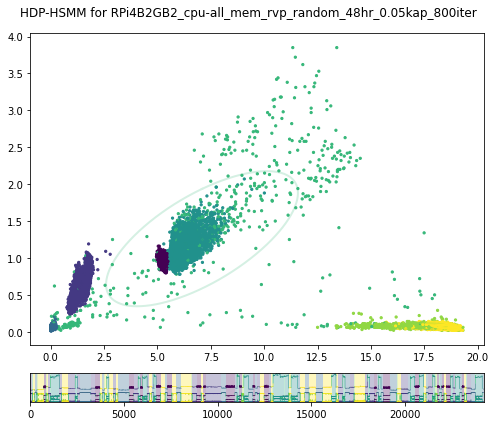

Training for 2 extra states, kappa = 0.08, and iters = 800
.........................  [  25/800,   36.34sec avg, ETA 07:49:26 ]
.........................  [  50/800,   36.38sec avg, ETA 07:34:48 ]
.........................  [  75/800,   36.40sec avg, ETA 07:19:47 ]
.........................  [ 100/800,   36.22sec avg, ETA 07:02:36 ]
.........................  [ 125/800,   36.20sec avg, ETA 06:47:18 ]
.........................  [ 150/800,   36.16sec avg, ETA 06:31:45 ]
.........................  [ 175/800,   36.15sec avg, ETA 06:16:35 ]
.........................  [ 200/800,   36.16sec avg, ETA 06:01:37 ]
.........................  [ 225/800,   36.14sec avg, ETA 05:46:19 ]
.........................  [ 250/800,   36.09sec avg, ETA 05:30:50 ]
.........................  [ 275/800,   36.10sec avg, ETA 05:15:52 ]
.........................  [ 300/800,   36.06sec avg, ETA 05:00:32 ]
.........................  [ 325/800,   36.09sec avg, ETA 04:45:43 ]
.........................  [ 350/800,   36.1

In [8]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.05,0.08,0.01], [800], "don't save fig")

In [9]:
labeled_data_train['predicted'] = state_sequences[0]

In [10]:
"""Training"""
Labels = {}
Accuracies = []

for name,group in labeled_data_train.groupby('state'):
    print(name)
    label = labeled_data_train.groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
    print(label)
    Labels[name] = label.idxmax()
    Accuracies.append(label.max())

augmented_reality
0    0.986722
4    0.013017
1    0.000260
Name: predicted, dtype: float64
game
6    0.988466
4    0.011534
Name: predicted, dtype: float64
idle
2    0.985972
4    0.014028
Name: predicted, dtype: float64
mining
5    0.843615
1    0.135545
4    0.020840
Name: predicted, dtype: float64
stream
3    0.926464
4    0.073322
6    0.000214
Name: predicted, dtype: float64


In [11]:
labeled_data_train['label'] = labeled_data_train['state'].map(Labels)
labeled_data_test['label'] = labeled_data_test['state'].map(Labels)
#create rolling window for prediction evaluations
for pw in prediction_windows: 
    labeled_data_test[f'label - {pw} step'] = [list(map(int,window.to_list())) for window in labeled_data_test['label'].rolling(window=pw)]
    labeled_data_test[f'label - {pw} step'] = labeled_data_test[f'label - {pw} step'].shift(1-pw)

In [12]:
"""Prepares test data, predictions start after lookback period"""
prediction_start = lookback
test_labels = labeled_data_test['state'].values
df = labeled_data_test[features]

In [13]:
"""Generates Label Predictions"""


for prediction_window in prediction_windows:

    predicted_observations_list, observations_list = [], []
    predicted_stateseq_list = []
    test_labels_window_list = []
    log_likelihoods_list = []

    print(f"{prediction_window}-step prediction")

    for i in tqdm(range(prediction_start,len(labeled_data_test)+1)):
        
        seed_start_idx =  i - lookback
        seed_end_idx = seed_start_idx + lookback
        
        if seed_end_idx > len(labeled_data_test)-prediction_window:
            break
        
        predicted_observations, predicted_stateseq, log_likelihood = SM.HSMM_pred(model,seed_start_idx, seed_end_idx, prediction_window)
        
        predicted_observations_list.append(predicted_observations[lookback:].tolist())
        predicted_stateseq_list.append(predicted_stateseq[lookback:].tolist())
        log_likelihoods_list.append(round(log_likelihood,2))
        observations_list.append(df[i:i+prediction_window].values)

        test_labels_window_list.append(test_labels[i:i+prediction_window])  

    # store results
    predicted_stateseq_list = ['lookback']*lookback + predicted_stateseq_list
    log_likelihoods_list = ['lookback']*lookback + log_likelihoods_list


    if len(labeled_data_test) != len(predicted_stateseq_list):
        
        if prediction_window != 1:
            labeled_data_test = labeled_data_test[:-(prediction_window-1)]

    labeled_data_test[f'predicted states - {prediction_window} step'] = predicted_stateseq_list
    labeled_data_test[f'log_likelihood - {prediction_window} step'] = log_likelihoods_list

print("Done!")

1-step prediction


100%|█████████▉| 10068/10069 [12:32<00:00, 13.38it/s]


2-step prediction


100%|█████████▉| 10067/10069 [13:01<00:00, 12.88it/s]


5-step prediction


100%|█████████▉| 10063/10068 [12:35<00:00, 13.31it/s]


10-step prediction


100%|█████████▉| 10054/10064 [12:51<00:00, 13.03it/s]


15-step prediction


100%|█████████▉| 10040/10055 [12:56<00:01, 12.93it/s]


30-step prediction


100%|█████████▉| 10011/10041 [13:51<00:02, 12.04it/s]


60-step prediction


 99%|█████████▉| 9952/10012 [13:14<00:04, 12.52it/s]

Done!


In [14]:
"""Testing"""
for name,group in labeled_data_test.groupby('state'):
    print(name)
    print(labeled_data_test[lookback:].groupby('state').get_group(name)[f'predicted states - {1} step'].value_counts(normalize=True))

augmented_reality
[0]    0.938462
[4]    0.054487
[6]    0.003205
[3]    0.001923
[5]    0.000641
[2]    0.000641
[1]    0.000641
Name: predicted states - 1 step, dtype: float64
game
[6]    0.960046
[4]    0.033105
[1]    0.002283
[3]    0.001903
[5]    0.001522
[0]    0.000761
[2]    0.000381
Name: predicted states - 1 step, dtype: float64
idle
[2]    0.920786
[4]    0.074449
[5]    0.001787
[3]    0.001191
[6]    0.001191
[1]    0.000596
Name: predicted states - 1 step, dtype: float64
mining
[5]    0.826772
[1]    0.132006
[4]    0.026401
[2]    0.008337
[0]    0.002316
[3]    0.002316
[6]    0.001853
Name: predicted states - 1 step, dtype: float64
stream
[3]    0.861890
[4]    0.111630
[6]    0.009865
[1]    0.006231
[2]    0.005711
[0]    0.004154
[5]    0.000519
Name: predicted states - 1 step, dtype: float64


In [15]:
"""Save test predictons"""
test_name = data_name
labeled_data_test.to_csv(f"data/{device_name}_{freq}MHz_res_usage_data_test_pred_{test_name}.csv")

In [16]:
"""remove lookback section"""
labeled_data_test = labeled_data_test[lookback:]

In [17]:
"""Accuracy Calculations"""
for prediction_window in prediction_windows:
    accuracy = []
    for index, row in labeled_data_test.iterrows():
        accuracy.append(accuracy_score(row[f'label - {prediction_window} step'], row[f'predicted states - {prediction_window} step'])*100)

    labeled_data_test[f'accuracy - {prediction_window} step'] = accuracy

    print(f"{prediction_window} step prediction accuracy: {round(mean(accuracy),2)}%")

1 step prediction accuracy: 90.21%
2 step prediction accuracy: 88.49%
5 step prediction accuracy: 83.75%
10 step prediction accuracy: 79.07%
15 step prediction accuracy: 75.31%
30 step prediction accuracy: 68.09%
60 step prediction accuracy: 56.24%
